In [75]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [76]:
# Macros.
# TODO: specify your paths.
MAX_ITER = 20
DATA_PATH = "gs://eric_586_big_data/Assignment2/data.txt" 
C1_PATH = "gs://eric_586_big_data/Assignment2/cent1.txt"
C2_PATH = "gs://eric_586_big_data/Assignment2/cent2.txt"
#NORM = 1  # change to 1 for l1 loss, change to 2 for l2 loss

In [77]:
# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm) ** norm)
                     for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    dist = linalg.norm(p - centroids[closest_c], norm) ** norm
    return [closest_c,dist]

In [78]:
def closest_helper(p, centroids, norm):
    results = closest(p,centroids,norm)
    return (results[0],(p,1,results[1]))

In [79]:
#NOT USED ANYMORE, REPLACED BY CLOSEST_HELPER
def calc_cost(closest, point, centroids, norm):
    
    distance = linalg.norm(point - centroids[closest], norm) ** norm
    
    return distance

In [80]:
def plot_cost(c1_cost, c2_cost, norm):
    print("Plot cost function, Distance: L{}.".format(norm))
    plt.plot(range(len(c1_cost)), c1_cost, "b", label="Cost of cent1.txt")
    plt.plot(range(len(c2_cost)), c2_cost, "r", label="Cost of cent2.txt")
    plt.title("Results using L{} Distance".format(norm))
    plt.legend(loc="upper right")
    plt.xlabel("Iteration")
    plt.ylabel("Within-Cluster Cost")
    plt.show()

In [81]:
# K-means clustering
def kmeans(data, centroids, norm):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        centroids: a list of centroids
        loss: a list of loss for each steps.
    """
    # iterative k-means
    # TODO: implement your logic here
    
    
    current_centroids = centroids

    cost_per_iter = []

    for _ in range(MAX_ITER):   
        
        # Transform each point to a combo of point, closest centroid, count=1
        data_with_centroids = data.map(lambda x : closest_helper(x,current_centroids,norm))
        
        # Re-compute cluster center
        # For each cluster center (key), aggregate its values by summing up points and count
        centroids_costs = data_with_centroids.reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1],x[2]+y[2]))
        
        # Average the points for each centroid: divide sum of points by count
        new_centroids = centroids_costs.map(lambda x : (x[0],(x[1][0]/x[1][1],x[1][2]))).collect()
        
        centroids_list_new = []
        cost = 0
        for element in new_centroids:
            centroids_list_new.append(element[1][0])
            cost += element[1][1]
            
            
        current_centroids = centroids_list_new
        cost_per_iter.append(cost)
        
    return [cost_per_iter,current_centroids,data_with_centroids]    


In [82]:
# Help function to visualize the tSNE clustering
def tSNE_graph(combo_points, random_seed, init_cluster, norm):
    """
    Conduct t-SNE reduction for points
    to 2D space and visualize the clustering
    result in the graph.
    Args:
        combo_points (RDD): a RDD of (centroid, (point, 1))
    Returns:
        tSNE_plot: a plot of clustering in 2D space
    """
    labels = np.array(combo_points.map(lambda v: v[0]).collect())
    points = np.array(combo_points.map(lambda v: v[1][0]).collect())
    points_embedded = TSNE(n_components = 2, random_state = random_seed).fit_transform(points)
    print('Shape: ' + str(points.shape) + ' -> ' + str(points_embedded.shape))
    
    plt.figure()
    plt.scatter(points_embedded[:, 0], points_embedded[:, 1])
    plt.title('{}, Distance: L{}, Before Clustering'.format(init_cluster, norm))
    plt.show()
    
    plt.scatter(points_embedded[:, 0], points_embedded[:, 1], c = labels)
    plt.title('{}, Distance: L{}, After Clustering'.format(init_cluster, norm))
    plt.show()

In [83]:
def main():
    # Spark settings
    conf = SparkConf()
    sc = SparkContext.getOrCreate(conf=conf)

    #Alternative
    #sc = SparkContext.getOrCreate()
    
    # Load the data, cache this since we're accessing this each iteration
    data = sc.textFile(DATA_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).cache()
    # Load the initial centroids c1, split into a list of np arrays
    centroids1 = sc.textFile(C1_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()
    # Load the initial centroids c2, split into a list of np arrays
    centroids2 = sc.textFile(C2_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()
    
    # TODO: implement your logic here 
    for norm in range(2):
        random_seed = np.random.randint(100)
        c1_results = kmeans(data,centroids1,norm+1)
        c2_results = kmeans(data,centroids2,norm+1)
        plot_cost(c1_results[0],c2_results[0],norm+1)
        
        tSNE_graph(c1_results[2],random_seed,'centroids1',norm+1)
        tSNE_graph(c2_results[2],random_seed,'centroids2',norm+1)
        
    #print(c1_cost)

Plot cost function, Distance: L1.


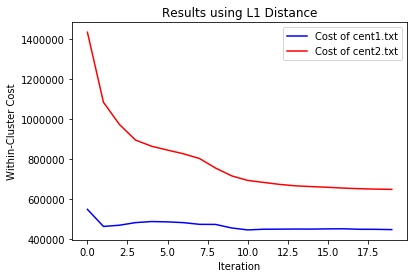

Shape: (4601, 58) -> (4601, 2)


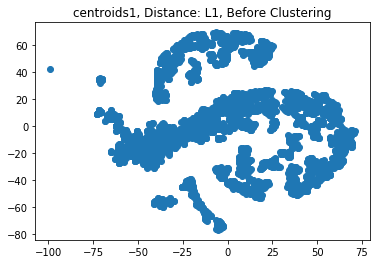

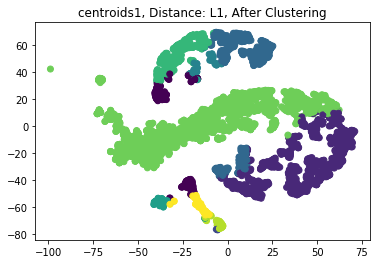

Shape: (4601, 58) -> (4601, 2)


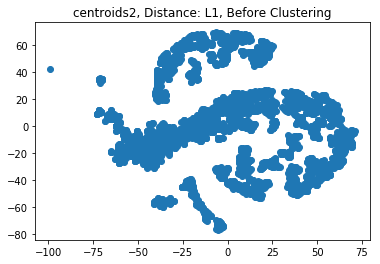

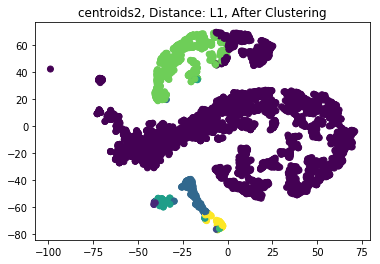

Plot cost function, Distance: L2.


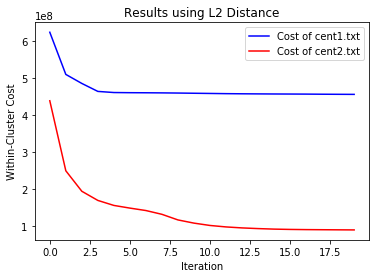

Shape: (4601, 58) -> (4601, 2)


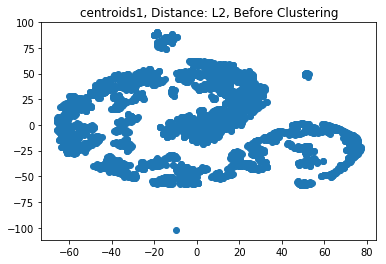

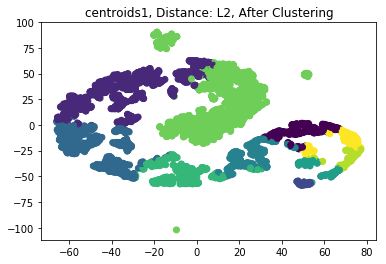

Shape: (4601, 58) -> (4601, 2)


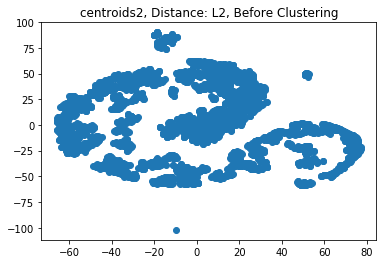

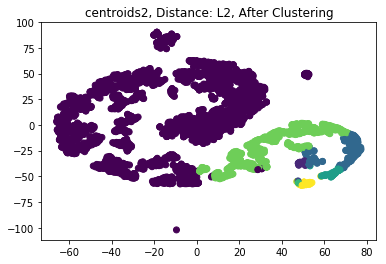

In [84]:
if __name__ == "__main__":
    main() 